### TabNet, a novel deep learning architecture for tabular learning. TabNet uses a sequential attention mechanism to choose a subset of semantically meaningful features to process at each decision step.TabNet uses canonical DNNs to act as decision trees .
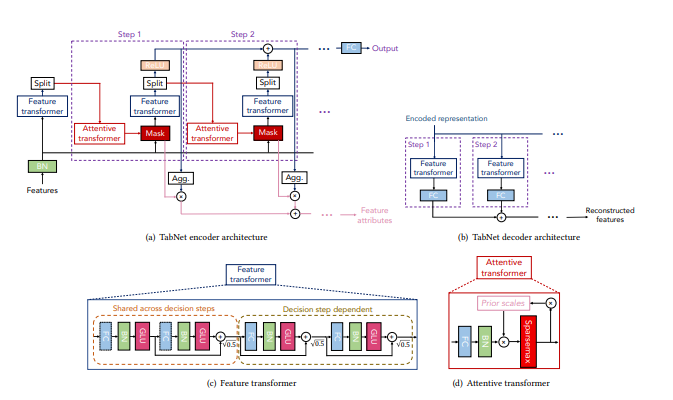


### Above represented encoder decoder architecture for TabNet. 
#### (a) TabNet encoder for classification or regression, composed of a feature transformer, an attentive transformer and feature masking at each decision step. A split block divides the processed representation into two, to be used by the attentive transformer of the subsequent step as well as for constructing the overall output. At each decision step, the feature selection mask can provide interpretable information about the model’s functionality, and the masks can be aggregated to obtain global feature important attribution. (b) TabNet decoder, composed of a feature transformer block at each step. (c) A feature transformer block example – 4-layer network is shown, where 2 of the blocks are shared across all decision steps and 2 are decision step-dependent. Each layer is composed of a fully-connected (FC) layer, BN and GLU nonlinearity. (d) An attentive transformer block example – a single layer mapping is modulated with a prior scale information which aggregates how much each feature has been used before the current decision step. Normalization of the coefficients is done using sparsemax for sparse selection of the most salient features at each decision step. (Collected from Original Paper)


## Installation

In [ ]:
!pip install pytorch-tabnet

# Library

In [ ]:
#===========================================================
# Library
#===========================================================
import os
import gc
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from contextlib import contextmanager
import time
import glob

import numpy as np
import pandas as pd
import scipy as sp
import random

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn import preprocessing
import category_encoders as ce
from sklearn.metrics import mean_squared_error

import torch
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
np.random.seed(0)

from pytorch_tabnet.tab_model import TabNetRegressor ##Import Tabnet 



from pathlib import Path

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.listdir('../input/indoor-location-navigation/')

# Utils

In [ ]:
#===========================================================
# Utils
#===========================================================
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    
def load_df(path, df_name, debug=False):
    if path.split('.')[-1]=='csv':
        df = pd.read_csv(path)
        if debug:
            df = pd.read_csv(path, nrows=1000)
    elif path.split('.')[-1]=='pkl':
        df = pd.read_pickle(path)
    if logger==None:
        print(f"{df_name} shape / {df.shape} ")
    else:
        logger.info(f"{df_name} shape / {df.shape} ")
    return df

# Config

In [ ]:
#===========================================================
# Config
#===========================================================
OUTPUT_DICT = ''

ID = 'Id'
TARGET_COLS = ['x', 'y', 'f']
SEED = 42
seed_everything(seed=SEED)

N_FOLD = 3

# Data Loading

In [ ]:
sample_submission = pd.read_csv('../input/indoor-location-navigation/sample_submission.csv')

## MODEL

### As per TabNet Paper , TabNet has three specialities : 
    a) Unlike tree-based methods, TabNet inputs raw tabular data
    b)TabNet uses sequential aention 
    c) Trained using Gradient -Descent Based Optimizations
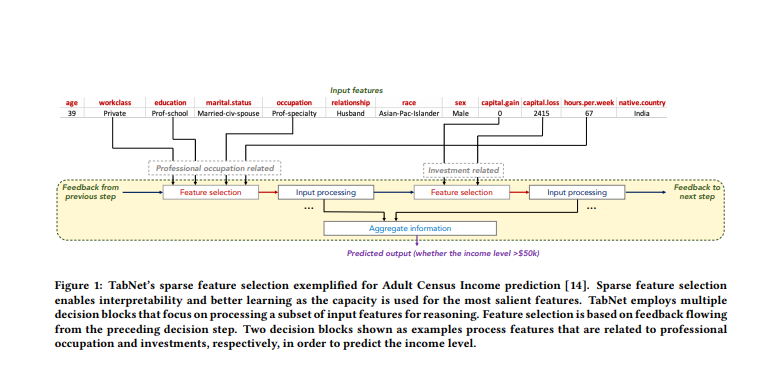

In [ ]:
# the metric used in this competition
def comp_metric(y_pred, y_true):
    xhat = y_pred[:, 0]
    yhat = y_pred[:, 1]
    fhat = y_pred[:, 2]
    x = y_true[:, 0]
    y = y_true[:, 1]
    f = y_true[:, 2]
    intermediate = np.sqrt(np.power(xhat - x,2) + np.power(yhat-y,2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

In [ ]:
def my_loss_fn(y_pred, y_true):
    xhat = y_pred[:, 0]
    yhat = y_pred[:, 1]
    fhat = y_pred[:, 2]
    x = y_true[:, 0]
    y = y_true[:, 1]
    f = y_true[:, 2]
    intermediate = torch.sqrt(torch.pow(xhat - x,2) + torch.pow(yhat-y,2)) + 15 * torch.absolute(fhat-f)
    return torch.mean(intermediate)

In [ ]:
#===========================================================
# model
#===========================================================
def run_single_tabnet(clf,train_df, test_df, folds, features, target, fold_num=0, categorical=[]):
    
    trn_idx = folds[folds.fold != fold_num].index
    val_idx = folds[folds.fold == fold_num].index
    logger.info(f'len(trn_idx) : {len(trn_idx)}')
    logger.info(f'len(val_idx) : {len(val_idx)}')
    X_train= train_df.iloc[trn_idx][features].values ###Converted this into Numpy array because TabNet will give error otherwise .
    y_train=target.iloc[trn_idx].values
    X_valid = train_df.iloc[val_idx][features].values
    y_valid= target.iloc[val_idx].values

    oof = np.zeros((len(train_df), target.shape[-1]))
    predictions = np.zeros((len(test_df), target.shape[-1]))
    

    clf.fit(
                X_train=X_train, y_train=y_train, ##Train features and train targets
                eval_set=[(X_valid, y_valid)],
                loss_fn = my_loss_fn,
                weights =0,#0 for no balancing,1 for automated balancing,dict for custom weights per class
                max_epochs=1000,##Maximum number of epochs during training , Default 1000. I used 10
                patience=70, ##Number of consecutive non improving epoch before early stopping , Default 50
                batch_size=1024, ##Training batch size
                virtual_batch_size=128 )##Batch size for Ghost Batch Normalization (virtual_batch_size < batch_size)

    oof[val_idx.tolist()] = clf.predict(train_df.iloc[val_idx][features].values)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = fold_num

    predictions += clf.predict(test_df[features].values)
    
    # RMSE
    logger.info("fold{} RMSE score: {:<8.5f}".format(fold_num, np.sqrt(mean_squared_error(target.loc[val_idx], oof[val_idx.tolist()]))))
    
    return oof, predictions, fold_importance_df


def run_kfold_tabnet(clf,train, test, folds, features, target, n_fold=5, categorical=[]):
    
    logger.info(f"================================= {n_fold}fold TabNet =================================")
    
    oof = np.zeros((len(train), target.shape[-1]))
    predictions = np.zeros((len(test), target.shape[-1]))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):
        print("Fold {}".format(fold_))
        _oof, _predictions, fold_importance_df = run_single_tabnet(clf,train,
                                                                     test,
                                                                     folds,
                                                                     features,
                                                                     target,
                                                                     fold_num=fold_,
                                                                     categorical=categorical)
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        oof += _oof
        predictions += _predictions / n_fold

    # RMSE
    logger.info("CV RMSE score: {:<8.5f}".format(np.sqrt(mean_squared_error(target, oof))))

    logger.info(f"=========================================================================================")
    
    return feature_importance_df, predictions, oof

    
def show_feature_importance(feature_importance_df, sitename):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{sitename}.png')
    plt.show()

In [ ]:
# prediction_dict = {}
# oof_dict = {}

# # for TARGET in TARGET_COLS: ## I think this model will work for multiple targets altogether , let me try that later

# logger.info(f'### TABNET for {TARGET_COLS} ###')

# target = train[TARGET_COLS]
# test[TARGET] = np.nan

# # features
# cat_features = []
# num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
# features = num_features + cat_features
# drop_features = [ID] + TARGET_COLS
# features = [c for c in features if c not in drop_features]

# if cat_features:
#     ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
#     ce_oe.fit(train)
#     train = ce_oe.transform(train)
#     test = ce_oe.transform(test)

# cat_idxs = [ i for i, f in enumerate(features) if f in cat_features]

# cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in cat_features]    

# clf = TabNetRegressor(
#                     n_d = 16,##Width of the decision prediction layer. Bigger values gives more capacity to the model with the risk of overfitting. Values typically range from 8 to 64.
#                     n_a = 16,##Width of the attention embedding for each mask. According to the paper n_d=n_a is usually a good choice. (default=8)
#                     n_steps = 3,##Number of steps in the architecture (usually between 3 and 10)
#                     gamma =1.3,##This is the coefficient for feature reusage in the masks. A value close to 1 will make mask selection least correlated between layers. Values range from 1.0 to 2.0.
#                     cat_idxs=cat_idxs, ##List of categorical features indices.
#                     cat_dims=cat_dims,
#                     cat_emb_dim =1, ##List of embeddings size for each categorical features. (default =1)
#                     n_independent =2,##Number of independent Gated Linear Units layers at each step. Usual values range from 1 to 5.
#                     n_shared =2,##Number of shared Gated Linear Units at each step Usual values range from 1 to 5
#                     epsilon  = 1e-15,##Should be left untouched.
#                     seed  =0,##Random seed for reproducibility
#                     momentum = 0.02, ##Momentum for batch normalization, typically ranges from 0.01 to 0.4 (default=0.02)
# #                         lr = 0.01, ##Initial learning rate used for training. As mentionned in the original paper, a large initial learning of 0.02 with decay is a good option.
#                     clip_value =None,
#                     lambda_sparse =1e-3,##This is the extra sparsity loss coefficient as proposed in the original paper. The bigger this coefficient is, the sparser your model will be in terms of feature selection. Depending on the difficulty of your problem, reducing this value could help.
#                     optimizer_fn =torch.optim.Adam, ## Optimizer
#                     scheduler_fn = None, #torch.optim.lr_scheduler.ReduceLROnPlateau, ## LR scheduler 
#                     scheduler_params = None,#{"mode":'min', "factor":0.1, "patience":10, "verbose":"False"}, ## LR scheduler parameters dictionary
#                     verbose =1,
#                     device_name = 'auto' ## Auto or 'gpu' ## I have no GPU

#                     )    

# feature_importance_df, predictions, oof = run_kfold_tabnet(clf,train, test, folds, features, target, 
#                                                              n_fold=N_FOLD, categorical=cat_features)

# prediction_dict = predictions
# oof_dict = oof

# show_feature_importance(feature_importance_df, TARGET)

# Training

In [ ]:
# get our train and test files
feature_dir = '../input/generate-wifi-features-5-times-faster/'

train_files = sorted(glob.glob(os.path.join(feature_dir, '*_train.csv')))
test_files = sorted(glob.glob(os.path.join(feature_dir, '*_test.csv')))
ssubm = pd.read_csv('../input/indoor-location-navigation/sample_submission.csv', index_col=0)

In [ ]:
subm_predictions = list()

for e, train_file in enumerate(train_files):
    train = pd.read_csv(train_file).reset_index().rename(columns={'index':'Id'})
    train = train.sample(frac=1, random_state=10)
    train['Id'] = range(0,len(train))
    train = train.set_index('Id')
    train = train.reset_index()
    
    test = pd.read_csv(test_files[e]).reset_index().rename(columns={'index':'Id'})
    
    
#     # Comment this to train using all data
#     train_size = int(len(train) * 0.8)
#     # --- Data Validation ---
#     # Valid features + targets
#     local_valid = train.iloc[train_size:, :]
#     # Train features + targets
#     train = train.iloc[:train_size, :]

     
    
    folds = train[[ID]+TARGET_COLS].copy()
    Fold = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
    for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET_COLS])):
        folds.loc[val_index, 'fold'] = int(n)
    folds['fold'] = folds['fold'].astype(int)
    folds.head()

    prediction_dict = {}
    oof_dict = {}

    # for TARGET in TARGET_COLS: ## I think this model will work for multiple targets altogether , let me try that later
    site = train_file.split('/')[-1].split('_')[0]
    logger.info(f'### TABNET for {TARGET_COLS} of site {e}: {site} ###')

    target = train[TARGET_COLS]
    test[TARGET_COLS] = np.nan

    # features
    cat_features = []
    num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
    features = num_features + cat_features
    drop_features = [ID] + TARGET_COLS
    features = [c for c in features if c not in drop_features]

    if cat_features:
        ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
        ce_oe.fit(train)
        train = ce_oe.transform(train)
        test = ce_oe.transform(test)

    cat_idxs = [ i for i, f in enumerate(features) if f in cat_features]

    cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in cat_features]    

    clf = TabNetRegressor(
                        n_d = 32,##Width of the decision prediction layer. Bigger values gives more capacity to the model with the risk of overfitting. Values typically range from 8 to 64.
                        n_a = 32,##Width of the attention embedding for each mask. According to the paper n_d=n_a is usually a good choice. (default=8)
                        n_steps = 3,##Number of steps in the architecture (usually between 3 and 10)
                        gamma =1.3,##This is the coefficient for feature reusage in the masks. A value close to 1 will make mask selection least correlated between layers. Values range from 1.0 to 2.0.
                        cat_idxs=cat_idxs, ##List of categorical features indices.
                        cat_dims=cat_dims,
                        cat_emb_dim =1, ##List of embeddings size for each categorical features. (default =1)
                        n_independent =2,##Number of independent Gated Linear Units layers at each step. Usual values range from 1 to 5.
                        n_shared =2,##Number of shared Gated Linear Units at each step Usual values range from 1 to 5
                        epsilon  = 1e-15,##Should be left untouched.
                        seed  =42,##Random seed for reproducibility
                        momentum = 0.02, ##Momentum for batch normalization, typically ranges from 0.01 to 0.4 (default=0.02)
                        optimizer_params = dict(lr=0.01),##Initial learning rate used for training. As mentionned in the original paper, a large initial learning of 0.02 with decay is a good option.
                        clip_value =None,
                        lambda_sparse =1e-5,##This is the extra sparsity loss coefficient as proposed in the original paper. The bigger this coefficient is, the sparser your model will be in terms of feature selection. Depending on the difficulty of your problem, reducing this value could help.
                        optimizer_fn =torch.optim.Adam, ## Optimizer
                        scheduler_fn = None, #torch.optim.lr_scheduler.ReduceLROnPlateau, ## LR scheduler 
                        scheduler_params = None,#{"mode":'min', "factor":0.1, "patience":10, "verbose":"False"}, ## LR scheduler parameters dictionary
                        verbose =1,
                        device_name = 'cuda' ## Auto or 'gpu' ## I have no GPU

                        )    

    feature_importance_df, prediction_dict, oof_dict = run_kfold_tabnet(clf,train, test, folds, features, target, 
                                                                 n_fold=N_FOLD, categorical=cat_features)

    
    
    test_predsx = prediction_dict[:, 0]
    test_predsy = prediction_dict[:, 1]
    test_predsf = prediction_dict[:, 2]
    
    test_preds = pd.DataFrame(np.stack((test_predsf, test_predsx, test_predsy))).T
    test_preds.columns = ssubm.columns
    test_preds.index = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    subm_predictions.append(test_preds)
    
    # save tabnet model
    saving_path_name = f"tabnet_model_test_{e}"
    saved_filepath = clf.save_model(saving_path_name)
    
    score = comp_metric(oof_dict, train[['x', 'y', 'f']].to_numpy())
    logger.info(f'Local OOF Score site {e}: {score}')
    
#     local_valid_score = comp_metric(clf.predict(local_valid.drop(columns = [ID] + TARGET_COLS + ['path']).to_numpy()), local_valid[['x', 'y', 'f']].to_numpy())
#     logger.info(f'Local Valid Score site {e}: {local_valid_score}')
    
#     show_feature_importance(feature_importance_df, site)

# Submission

In [ ]:
# generate prediction file 
all_preds = pd.concat(subm_predictions)
all_preds = all_preds.reindex(ssubm.index)
all_preds.to_csv('submission.csv')

In [ ]:
last_subm = pd.read_csv('../input/lightgdm-baseline-wifi-features/submission.csv')
last_subm.head(30)